# Enhanced protein isoform characterization through long-read proteogenomics 
## Supplementary Figure 2e
---
Ben Jordan | Gloria Sheynkman

### Supplementary Fig. 2: Generation and characterization of candidate protein isoform sequences from long-read RNA-seq data. 

e, Fraction of genes for which the most abundant transcript underlying the protein isoform does not correspond to the APPRIS reference. 

In [15]:
from re import S
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from collections import defaultdict
from matplotlib import rc
import os, sys
import matplotlib
import dataframe_image as dfi
import appris_helper


# currentdir = os.path.dirname(os.path.realpath(__file__))
# parentdir = os.path.dirname(currentdir)
# sys.path.append(parentdir)
import config

matplotlib.rc('font', **config.font)

# all plots go into a directory
if not os.path.exists('plot'):
    os.makedirs('plot')

# all statistics go into a directory
if not os.path.exists('stats'):
    os.makedirs('stats')

# file paths
sqanti_info_file = f"{config.PIPELINE_RESULTS_DIRECTORY}/transcriptome_summary/sqanti_isoform_info.tsv"
sqanti_file = f'{config.PIPELINE_RESULTS_DIRECTORY}/sqanti3-filtered/jurkat_classification.5degfilter.tsv'




appris_info_file = '0_pre_analysis/appris_transcripts.tsv'
gencode_isoforms_file = '0_pre_analysis/gene_isoname_isbasic.tsv'
# protein_classification_file = f'{config.PIPELINE_RESULTS_DIRECTORY}/protein_classification/jurkat_unfiltered.protein_classification.tsv'
protein_classification_file = f'{config.PIPELINE_RESULTS_DIRECTORY}/protein_filter/jurkat.classification_filtered.tsv'
# refined_metadata_file = f'{config.PIPELINE_RESULTS_DIRECTORY}/hybrid_protein_database/jurkat_refined_high_confidence.tsv'
refined_metadata_file = f'{config.PIPELINE_RESULTS_DIRECTORY}/protein_gene_rename/jurkat_orf_refined_gene_update.tsv'

# read in files
appris_isonames = pd.read_table(appris_info_file)['isoname'].to_list()
sqanti_info = pd.read_table(sqanti_info_file)
sqanti_info['log2cpm'] = np.log2(sqanti_info['cpm'] + 1)
protein_classification = pd.read_table(protein_classification_file)
refined = pd.read_table(refined_metadata_file, usecols=['pb_accs', 'base_acc'])


base_acc_map = {}
for _, row in refined.iterrows():
    for acc in row['pb_accs'].split('|'):
        base_acc_map[acc] = row['base_acc']

sqanti_info['base_acc'] = sqanti_info['pb_acc'].map(base_acc_map)
sqanti_info = sqanti_info.dropna(subset=['base_acc'])
sqanti_info = sqanti_info[['base_acc','transcript', 'cpm','gene']].drop_duplicates()
sqanti_info = sqanti_info.merge(protein_classification[['pb','pclass']], left_on='base_acc', right_on= 'pb', how = 'inner')

def get_is_appris(row, appris_isonames):
    return row['pclass'] =='pFSM' and row['isoname'] in appris_isonames
sqanti_info['isoname'] = sqanti_info['transcript'].str.replace('_', '-')
  
sqanti_info['is_appris'] = sqanti_info.apply(lambda row: get_is_appris(row, appris_isonames), axis=1)




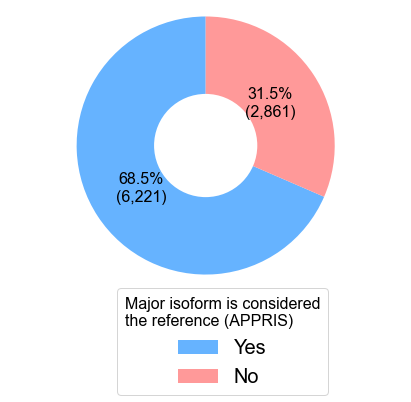

<Figure size 432x288 with 0 Axes>

In [16]:
# only do anlaysis with multi-isoform genes

donut_sqanti = sqanti_info.groupby('gene').filter(lambda x: len(x) > 1)

# get cpm fraction of each isoform by gene

major_isoform = appris_helper.get_major_isoform(donut_sqanti)
appris_helper.plot_appris_donut(major_isoform, 'SuppFig2e')


In [17]:
not_appris = major_isoform[~major_isoform['is_appris']]
not_appris_sizes = not_appris.groupby('pclass').size().reset_index(name='Number of protein isoforms')
not_appris_sizes.rename(columns = {'pclass': 'SQANTI protein class'}, inplace=True)
not_appris_sizes.to_csv('stats/SuppFig2e_not_appris_sizes.tsv', sep = '\t', index=False)

In [18]:
not_appris

,base_acc,transcript,cpm,pb,pclass,isoname,is_appris
gene,,,,,,,
AAK1,PB.2058.1,novel,0.817630,PB.2058.1,pNNC,novel,False
ABCB8,PB.6968.1,ABCB8-202,44.424567,PB.6968.1,pNIC,ABCB8-202,False
ABCC1,PB.12393.4,ABCC1-202,2.180347,PB.12393.4,pNNC,ABCC1-202,False
ABCC10,PB.5770.2,ABCC10-204,1.635260,PB.5770.2,pFSM,ABCC10-204,False
ABCC5,PB.3812.12,ABCC5-205,13.082081,PB.3812.12,pFSM,ABCC5-205,False
...,...,...,...,...,...,...,...
ZSCAN32,PB.12306.11,novel,12.536994,PB.12306.11,pFSM,novel,False
ZSCAN5A,PB.15115.3,novel,2.725434,PB.15115.3,pFSM,novel,False
ZSWIM9,PB.14965.3,novel,0.817630,PB.14965.3,pNNC,novel,False
